In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


import sys
PATH_TO_REPO = "/home/bis/2021_SJH_detectability/Detectability/compareModel/2021ACS_DeepDigest/"
sys.path.append(PATH_TO_REPO)

import time
start = time.time()
import read_protein_sequences
import cut_and_gene_tradata
import predictor
import sys
import getopt

# digestibility check data

In [5]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

df_detect_peptide_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test = test.loc[test.ID==1].reset_index(drop=True)
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(31)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(31)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
print(label_enc)

aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(19, 21)
{'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}
(543784, 39) (543784, 30) (543784, 31) (543784, 31) (543784, 31) (543784, 31) (543784,)
(135946, 39) (135946, 30) (135946, 31) (135946, 31) (135946, 31) (135946, 31) (135946,)
(67100, 39) (67100, 30) (67100, 31) (67100, 31) (67100, 31) (67100, 31) (67100,)


In [6]:
test['E1'] = test.E1.apply(lambda x: x.replace('-', 'Z'*31))
test['E2'] = test.E2.apply(lambda x: x.replace('-', 'Z'*31))

en = pd.DataFrame([[ts, 1] for ts in test.En.values], columns=['mers', 'label'])
ec = pd.DataFrame([[ts, 1] for ts in test.Ec.values], columns=['mers', 'label'])
e1 = pd.DataFrame([[ts, 0] for ts in test.E1.values], columns=['mers', 'label'])
e2 = pd.DataFrame([[ts, 0] for ts in test.E2.values], columns=['mers', 'label'])
df_mers = pd.concat([en, ec, e1, e2], axis=0).reset_index(drop=True)

# DeepDigest

In [7]:
from tensorflow.keras.models import model_from_json
import time
import re

print("Loading model...")
protease='Trypsin'
s3 = time.time()
# load architecture
json_file = open(PATH_TO_REPO+'%s.json'%protease, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load parameters
loaded_model.load_weights(PATH_TO_REPO+'%s.h5'%protease)
e3 = time.time()
print("Time cost of loading model was %s seconds."%(e3-s3))

Loading model...
Time cost of loading model was 0.28261780738830566 seconds.


In [8]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 21)            441       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 21)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 21)            903       
_________________________________________________________________
average_pooling1d_1 (Average (None, 29, 21)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 21)            903       
_________________________________________________________________
average_pooling1d_2 (Average (None, 27, 21)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21)               

In [9]:
loaded_model.pop()
loaded_model.pop()

In [10]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 21)            441       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 21)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 21)            903       
_________________________________________________________________
average_pooling1d_1 (Average (None, 29, 21)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 21)            903       
_________________________________________________________________
average_pooling1d_2 (Average (None, 27, 21)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21)               

In [12]:
del_idx = [idx for idx, p in zip(df_mers.index, df_mers.mers.values) if p =='Z'*31]
df_mers_onlyreal = df_mers.drop(del_idx, axis=0).reset_index(drop=True)

In [13]:
df_mers_onlyreal.label.value_counts()

1    134200
0     35745
Name: label, dtype: int64

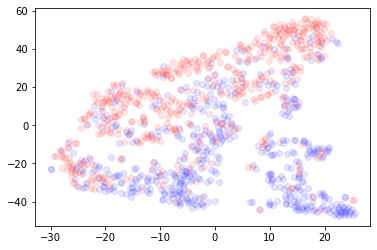

In [14]:
mers = df_mers_onlyreal.mers.values
X_test = np.array(predictor.coding(mers))

samples = np.concatenate([X_test[:500], X_test[-500:]])

vectors = loaded_model.predict(samples)

X_embedded = TSNE(n_components=2).fit_transform(vectors)
for x in range(0, len(X_embedded)):
    if x in range(0, 500):
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='blue', alpha=0.1)
    else:
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='red', alpha=0.1)

# whole

In [15]:
s = time.time()
samples = np.concatenate([X_test[:35745], X_test[-35745:]])

vectors = loaded_model.predict(X_test)
end = time.time()

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(vectors)
for x in range(0, len(X_embedded)):
    if x in range(0, 35745):
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='blue', alpha=0.1)
    else:
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='red', alpha=0.1)

# 3.6 tmp

In [18]:
tmp = pd.read_csv('../data/df_detect_peptide_test.csv')

tp = set(tmp.PEP.unique())
testp = set(test.PEP.unique())
print(len(tp), len(testp), len(tp.intersection(testp)))

remain_tmp_p = tp.intersection(testp)
remain_idx = [idx for idx, p in zip(test.index, test.PEP.values) if p in remain_tmp_p]
remain_test = test.loc[remain_idx].reset_index(drop=True)

132645 66253 27389


In [26]:
remain_test

,peptide,En,Ec,E1,E2,protein,PEP,ID
0,K.LRDDFEKK.M,DSEKPFRGSQSPKRYKLRDDFEKKMADFHKE,SQSPKRYKLRDDFEKKMADFHKEEMDDQDKD,EKPFRGSQSPKRYKLRDDFEKKMADFHKEEM,GSQSPKRYKLRDDFEKKMADFHKEEMDDQDK,sp|Q9Y2W1|TR150_HUMAN,LRDDFEKK,1
1,K.VKPNCNLR.V,DRAPFTVKNAVGVPIKVKPNCNLRVMGFPEK,NAVGVPIKVKPNCNLRVMGFPEKSDIFDVDA,APFTVKNAVGVPIKVKPNCNLRVMGFPEKSD,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,sp|Q709C8|VP13C_HUMAN,VKPNCNLR,1
2,R.SFLWQAQSFRSQLQK.K,EGDDLRILAQEITKARSFLWQAQSFRSQLQK,RSFLWQAQSFRSQLQKKNDAEPKVTLSZZZZ,EITKARSFLWQAQSFRSQLQKKNDAEPKVTL,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,sp|A6NCI4|VWA3A_HUMAN,SFLWQAQSFRSQLQK,1
3,R.CLAENSLGSAR.H,TLQLLKVGEEDDGEYRCLAENSLGSARHAYY,DGEYRCLAENSLGSARHAYYVTVEAAPYWLH,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,sp|P32004|L1CAM_HUMAN,CLAENSLGSAR,1
4,R.DANLYVSGLPK.T,KTIKVSYARPSSASIRDANLYVSGLPKTMTQ,SASIRDANLYVSGLPKTMTQKELEQLFSQYG,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,sp|P26378|ELAV4_HUMAN,DANLYVSGLPK,1
...,...,...,...,...,...,...,...,...
28055,R.SPQSLSAAIAAMQK.F,QYGYLPPGDLRTHTQRSPQSLSAAIAAMQKF,QRSPQSLSAAIAAMQKFYGLQVTGKADADTM,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,sp|P50281|MMP14_HUMAN,SPQSLSAAIAAMQK,1
28056,R.AGEGNEEISNMIHSYIKEIEDLR.A,RITQLVSDQANHVLARAGEGNEEISNMIHSY,ISNMIHSYIKEIEDLRAKLLESEAVNENLRK,GEGNEEISNMIHSYIKEIEDLRAKLLESEAV,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,sp|Q7Z4S6|KI21A_HUMAN,AGEGNEEISNMIHSYIKEIEDLR,1
28057,R.DKEFHSHLTSHEK.D,ERHTVKNLESLLATNRDKEFHSHLTSHEKDT,TNRDKEFHSHLTSHEKDTEIQLLKEKLTLSE,HTVKNLESLLATNRDKEFHSHLTSHEKDTEI,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,sp|Q66GS9|CP135_HUMAN,DKEFHSHLTSHEK,1
28058,R.QTCDIEGLVELLNR.V,SPSSLVKVPSSATGKRQTCDIEGLVELLNRV,KRQTCDIEGLVELLNRVQSSGAHDQRGLLRK,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ,sp|O43566|RGS14_HUMAN,QTCDIEGLVELLNR,1


In [27]:
en36 = pd.DataFrame([[ts, 1] for ts in remain_test.En.values], columns=['mers', 'label'])
ec36 = pd.DataFrame([[ts, 1] for ts in remain_test.Ec.values], columns=['mers', 'label'])
e136 = pd.DataFrame([[ts, 0] for ts in remain_test.E1.values if ts != 'Z'*31], columns=['mers', 'label'])
e236 = pd.DataFrame([[ts, 0] for ts in remain_test.E2.values if ts != 'Z'*31], columns=['mers', 'label'])

In [28]:
print(len(en36), len(ec36), len(e136), len(e236))

28060 28060 12468 2065


In [37]:
df_mers36 = pd.concat([en36[:7266], ec36[:7267], e136, e236], axis=0).reset_index(drop=True)

In [38]:
mers36 = df_mers36.mers.values
X_test36 = np.array(predictor.coding(mers36))

In [39]:
len(df_mers36)

29066

In [40]:
vectors = loaded_model.predict(X_test36)

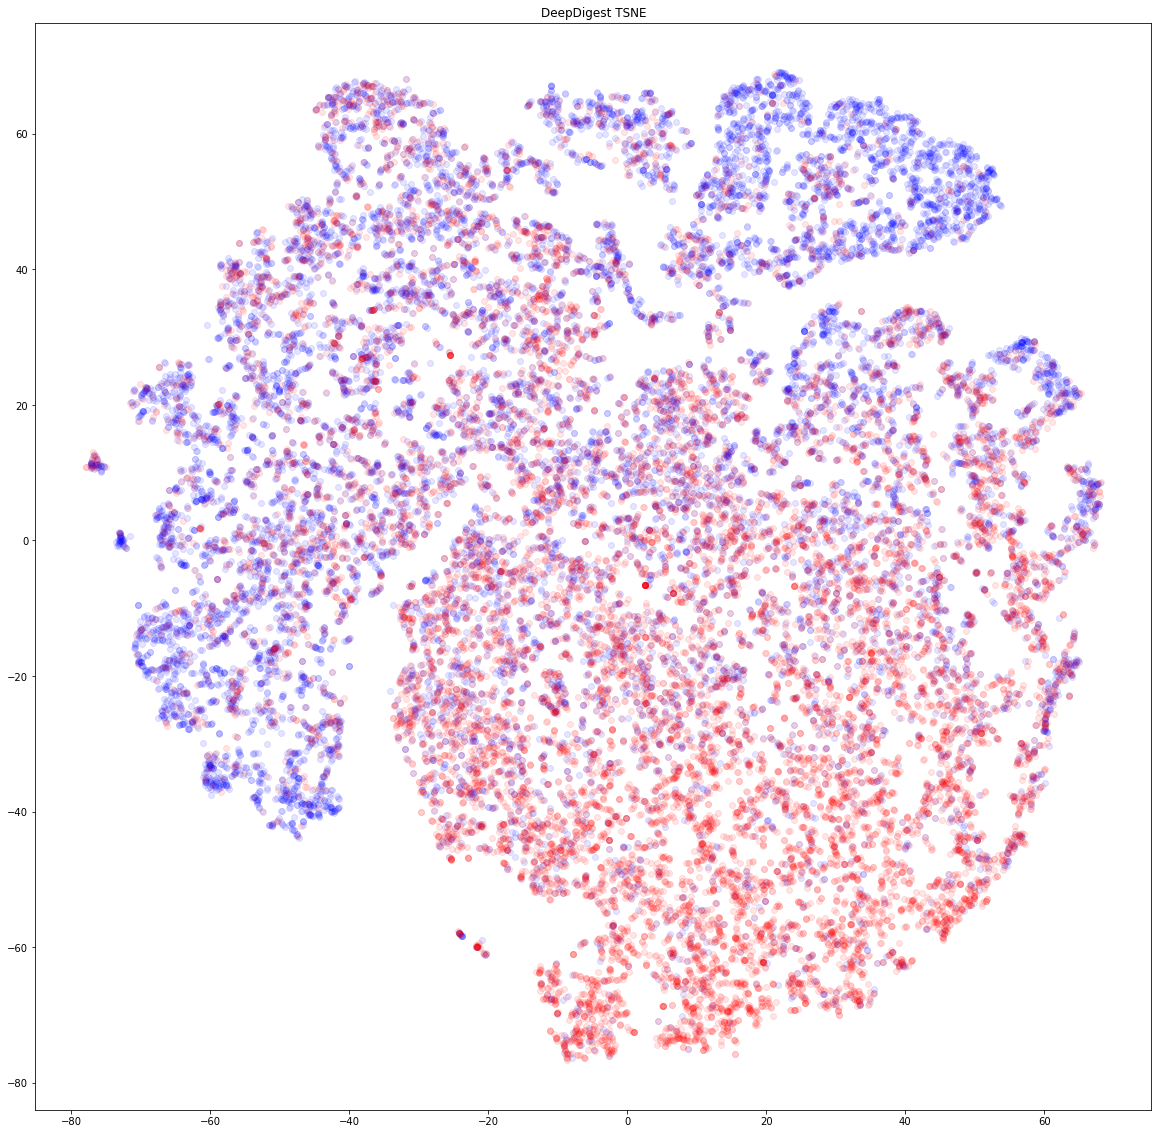

In [41]:
plt.figure(figsize=(20,20))

X_embedded = TSNE(n_components=2).fit_transform(vectors)
for x in range(0, len(X_embedded)):
    if x in range(0, 14533):
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='blue', alpha=0.1)
    else:
        plt.scatter(X_embedded[x][0],X_embedded[x][1], color='red', alpha=0.1)
        
plt.title('DeepDigest TSNE')
plt.show()